# **The use of machine learning in stock return prediction**

Professor Paul Geertsema

*Vlerick Business School, March 2024*




# Why predict returns?

- Return predictability is the study of various methods for predicting the future returns of financial assets

- There are two reasons for being interested in return predictability:

  - *Understanding*: Seeking to better understand the different components of expected returns as well as the influence of various behavioural biases and market frictions. (Academia)

  - *Making money*: If you can reliably predict risk-adjusted returns, it is almost like being able to print money. (Fund managers and trading desks)

- So even if you are not that interested in the determinants of expected returns, I suspect you are interested in making money ...

# Predicting stock returns are hard

Predicting stock returns are hard, even with machine learning. This is why:

1. Stock returns are really noisy. The signal-to-noise ratio is around ~ 0.03

2. When someone trades using a model, they are interfering directly with the data generating process (DGP), making past data less usefull for future prediction.

3. Short term investing vs the market is a zero-sum game

  - For every dollar made in excess of the market return, a dollar must be lost somewhere else

  - Which means it is an arms race

  - Which means you will lose (unless you are a top-tier hedge fund or trading desk - or very clever)

4. Unusually extreme events are unusually common in finance. (Tail risk / Black Swans)

5. Past data is finite and new data is generated at a finite rate. So over-fitting (data mining) cannot be easily controlled. (See also point 2.)

6. We can't experiment directly on the market (regulators tend to see your “experimentation” as market manipulation).

7. By the time you have enough data to be sure the strategy is really profitable, it has probably been exploited already.

8. *ML is easy* Tools and data are commodities. In ML, everyone has access to the same ML tools (the best ones are all open source) and the same market data (standard data providers). What, exactly, is your competitive edge?

9. *or, ML is hard* Mediocre ML skills are no use in finance (it is zero sum, remember?). So any excess returns you make will be spent on retaining the best ML/trading talent money can buy.

Still, no reason not to try, right?

# Let's run some code!

## Load the required packages

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

## Get the data

The dataset uses accounting data from the Compustat annual database and stock returns from CRSP.

We'll download a cleaned-up version of this dataset from my google drive.

Note: An "!" (exclamation mark) in front of something means that is should be run directly in the operating system (in this case Linux). The wget utility downloads a file from a source on the internet.

In [3]:
# download data from google drive to colab
!wget https://drive.google.com/uc?id=1jIBRnk_aiJPcYJIn2pKX7vUWNgliiKGp -O compustat_final.dta

# ls is short for "list" - this is to check that the file downloaded correctly
!ls

--2024-03-04 20:52:48--  https://drive.google.com/uc?id=1jIBRnk_aiJPcYJIn2pKX7vUWNgliiKGp
Resolving drive.google.com (drive.google.com)... 142.251.167.138, 142.251.167.139, 142.251.167.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.167.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jIBRnk_aiJPcYJIn2pKX7vUWNgliiKGp [following]
--2024-03-04 20:52:48--  https://drive.usercontent.google.com/download?id=1jIBRnk_aiJPcYJIn2pKX7vUWNgliiKGp
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.62.132, 2607:f8b0:4004:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.62.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48580396 (46M) [application/octet-stream]
Saving to: ‘compustat_final.dta’

compustat_final.dta 100%[===================>]  46.33M   125MB/s    in 0.4s    

2024-03-04 20:52:51 (1

In [4]:
# Open the file with pandas
df = pd.read_stata('compustat_final.dta', convert_dates = False)

## Variable descriptions

These are the variables in the dataset. Gvkey identifies firms, and year identifies the calendar year of the balance sheet date for accounting data. All accounting items are scaled by total assets in dollars (t_ta).


| Variable           | Description                         |
|-----------------|--------------------------------------------------------|
| gvkey           | Standard and Poor's Identifier                         |
| year            | Calendar year of balance sheet date                    |
| mth             | Balance sheet month                                    |
| ind_durbl       | Industry indicator                                     |
| ind_manuf       | Industry indicator                                     |
| ind_enrgy       | Industry indicator                                     |
| ind_chems       | Industry indicator                                     |
| ind_buseq       | Industry indicator                                     |
| ind_telcm       | Industry indicator                                     |
| ind_utils       | Industry indicator                                     |
| ind_shops       | Industry indicator                                     |
| ind_helth       | Industry indicator                                     |
| ind_money       | Industry indicator                                     |
| ind_other       | Industry indicator                                     |
| sale            | Sales/Turnover (Net)                                   |
| cogs            | Cost of Goods Sold                                     |
| xsga            | Selling, General and Administrative Expense            |
| dp              | Depreciation and Amortization                          |
| xint            | Interest and Related Expense - Total                   |
| spes            | Special and non-operating income                       |
| txt             | Income Taxes - Total                                   |
| mii             | Noncontrolling Interest (Income Account)               |
| divs            | Dividends from common and preferred equity (=dvp+dvc)  |
| xdo             | Extraordinary items, discontinued ops and common stock |
| che             | Cash and Short-Term Investments                        |
| rect            | Receivables - Total                                    |
| invt            | Inventories - Total                                    |
| aco             | Current Assets - Other - Total                         |
| ppent           | Property, Plant and Equipment - Total (Net)            |
| iva             | Investments in debt and equity (= ivaeq + ivao)        |
| intan           | Intangible Assets - Total                              |
| ao              | Assets - Other                                         |
| dlc             | Debt in Current Liabilities - Total                    |
| ap              | Accounts Payable - Trade                               |
| alo             | Other current liabilities                              |
| dltt            | Long-Term Debt - Total                                 |
| llo             | Ohter long-term liabilities                            |
| nei             | Net equity issuance                                    |
| mcap            | Market capitalisation in millions of dollars           |
| gp              | Gross Profit                                           |
| ebitda          | EBITDA                                                 |
| ebit            | Earnings before interest and tax                       |
| ebt             | Earnings before tax                                    |
| pi              | Income before tax                                      |
| ibmii           | Net income before minority interest                    |
| ib              | Income                                                 |
| niadj           | Net income to shareholders                             |
| act             | Current assets                                         |
| alt             | Long-term assets                                       |
| at              | Total assets                                           |
| lct             | Current liabilities                                    |
| llt             | Long-term liabilities                                  |
| lt              | Total liabilities                                      |
| eq              | Equity                                                 |
| oci             | Other Comprehensive Income                             |
| return          | Stock return (ex dividends) during reporting year      |
| next_year_ret~n | Stock return (ex dividends) for next reporting year    |
| t_ta            | Total assets in dollars                                |

**CHECKPOINT 1**


---


You now have a Pandas dataframe df. What is in it? Complete the cells below by replacing
...
REPLACEME
...
with the correct Python code.

*Hint*: The comments in each cell provide a usefull question for your favourite search engine (e.g. google) or large language model (e.g. chatgpt). Or you can use the "generate with AI" option in a new cell in colab.

In [ ]:
# View a few rows from the data
# Q: View the first 10 rows of a Pandas dataframe df
df.REPLACEME

In [ ]:
# View summary data (mean, min, max, etc.) of the data
# Q: View summary statistics of a Pandas dataframe df
df.REPLACEME

In [ ]:
# View the datatypes of the columns
# Q: List the datatypes for each of the columns in a Pandas dataframe
df.REPLACEME

In [ ]:
# List all variables in the dataset
# Q: List all the columns in Pandas dataframe df
df.REPLACEME

## Split 1: Train, validation and test

In [ ]:
# find chronological range
df.year.describe()

count    130835.000000
mean       1994.111331
std          15.157417
min        1962.000000
25%        1981.000000
50%        1994.000000
75%        2007.000000
max        2021.000000
Name: year, dtype: float64

In [ ]:
# Split data chronologically (since we are predicting - we can't train on future data!)
train = df[df['year'].between(1962, 1994)]
valid = df[df['year'].between(1995, 2001)]
test  = df[df['year'].between(2002, 2021)]

Train contains 66344 instances from 1962 to 1994
Valid contains 19347 instances from 1995 to 2001
Test contains 45144 instances from 2002 to 2021


**CHECKPOINT 2**


---

Replace "REPLACEME" with the correct code to print the number of instances and date range (minimum and maximum year) in the code cell below.

In [ ]:
print(f"Train contains {len(train)} instances from {REPLACEME} to {train.year.max()}")
print(f"Valid contains {REPLACEME} instances from {valid.year.min()} to {REPLACEME}")
print(f"Test contains {len(test)} instances from {REPLACEME} to {REPLACEME}")

## Split 2: Target and Features

In [ ]:
# The prediction target is the next year return
target = 'next_year_return'

# The prediction features are the remaining variables in the dataset
features = list(df.columns)
features.remove(target)

print(f"target: {target}")
print(f"features: {features}")
print(f"Target in features? {target in features}")

target: next_year_return
features: ['gvkey', 'year', 'mth', 'ind_durbl', 'ind_manuf', 'ind_enrgy', 'ind_chems', 'ind_buseq', 'ind_telcm', 'ind_utils', 'ind_shops', 'ind_helth', 'ind_money', 'ind_other', 'sale', 'cogs', 'xsga', 'dp', 'xint', 'spes', 'txt', 'mii', 'divs', 'xdo', 'che', 'rect', 'invt', 'aco', 'ppent', 'iva', 'intan', 'ao', 'dlc', 'ap', 'alo', 'dltt', 'llo', 'nei', 'mcap', 'gp', 'ebitda', 'ebit', 'ebt', 'pi', 'ibmii', 'ib', 'niadj', 'act', 'alt', 'at', 'lct', 'llt', 'lt', 'eq', 'oci', 'return', 't_ta']
Target in features? False


In [ ]:
# Split between features (X) and target (y)

X_train = train[features]
X_valid = valid[features]
X_test  =  test[features]

y_train = train[target]
y_valid = valid[target]
y_test  =  test[target]

**CHECKPOINT 3**


---

How many instances (rows) are there in the dataframe X_train? How many columns are there in dataframe X_train? Write code in the cell below to answer these questions.

In [ ]:
print(f"X_test contains {REPLACEME} instances and {REPLACEME} columns")

## Scale features

Neural networks train best if all the features are of a similar mean and variance. For this we use the StandardScalar from Scikit-Learn.

For some variable $ x $, the normalised version $ z $ is given by:

$ z = \frac{x-E[x]}{SD[x]} $

where the expectation ($ E[] $) and standard deviation ($ SD[] $) are taken over the dataset supplied.

Note: We perform scaling *separately* for each of the three data splits. This is to avoid "data leakage" between data splits. (Remark: In real life, can you take the expectation and standard deviation of a data set that spans both the past *and* the future?)

In [ ]:
# Standardize features (needed for neural network to train well)
# z = (x - x_mean)/x_stdev

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

## Define the model

We are using a 4-layer densely-connected (hence "Dense()") neural network. The input_shape is equal to the size of the features, and the output (last layer) is a single neuron that contains the prediction.

**CHECKPOINT 4**


---

Replace REPLACEME in the code below to implement a densely connected neural network layer with 32 nodes, ReLu activation and He initialization.

In [ ]:
# Define model

def createModel():
  tf.keras.utils.set_random_seed(42)
  model = Sequential([
    Dense(128, activation='relu', kernel_initializer=HeNormal(), input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    REPLACEME,
    Dense(1)  # A single output
  ])
  return model

# create model
model = createModel()


In [ ]:
type(model)

keras.src.engine.sequential.Sequential

## Train the model

We will train the model for 200 epochs. An epoch represents each time the neural network has trained using the entire dataset.

In [ ]:
# Train model

# Use batch size equal to entire training data set
# This ensures that the **training** error will be strictly decreasing with training
batch_size = len(X_train)
epochs = 200

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam())

# Fit the model
tf.keras.utils.set_random_seed(42)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1)
print("training complete!")

# Calculate RMSE
train_rmse = np.sqrt(history.history['loss'])
valid_rmse = np.sqrt(history.history['val_loss'])

# Print epoch with minimum RMSE
print('Min RMSE for training data at epoch:', np.argmin(train_rmse)+1)
print('Min RMSE for validation data at epoch:', np.argmin(valid_rmse)+1)


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 2.9815 - val_loss: 4.7568
Epoch 2/200
1/1 [==============================] - 1s 731ms/step - loss: 2.2891 - val_loss: 4.2531
Epoch 3/200
1/1 [==============================] - 1s 693ms/step - loss: 1.9803 - val_loss: 4.1248
Epoch 4/200
1/1 [==============================] - 1s 587ms/step - loss: 1.8890 - val_loss: 4.0607
Epoch 5/200
1/1 [==============================] - 0s 487ms/step - loss: 1.8551 - val_loss: 3.9398
Epoch 6/200
1/1 [==============================] - 0s 473ms/step - loss: 1.8033 - val_loss: 3.7717
Epoch 7/200
1/1 [==============================] - 0s 461ms/step - loss: 1.7255 - val_loss: 3.6027
Epoch 8/200
1/1 [==============================] - 0s 485ms/step - loss: 1.6406 - val_loss: 3.4767
Epoch 9/200
1/1 [==============================] - 0s 492ms/step - loss: 1.5682 - val_loss: 3.4178
Epoch 10/200
1/1 [==============================] - 0s 431ms/step - loss: 1.5200 - val_loss: 3.4236
Epoch 11/200

## Model evaluation


Min RMSE for training data at epoch: 200
Min RMSE for validation data at epoch: 183


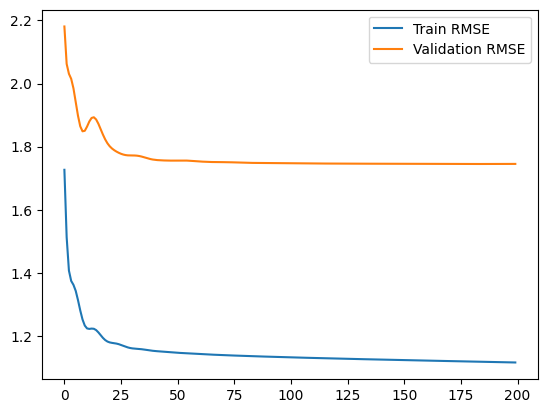

In [ ]:
# Print epoch with minimum RMSE
print('Min RMSE for training data at epoch:', np.argmin(train_rmse)+1)
print('Min RMSE for validation data at epoch:', np.argmin(valid_rmse)+1)

valid_epochs = np.argmin(valid_rmse)+1

# Plot RMSE
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Validation RMSE')

plt.legend()
plt.show()

# Test data performance

**CHECKPOINT 5**


---

Modify the code below so that we use the *test* dataset for validation instead of the validation data (as used in the previous code cell).

(We are doing this so we can easily construct the loss function curve for the test dataset.)

*Hint*: Look at the code cell starting with comment "# Train model". Simply copy the missing bits of code, but replace any occurances of "valid" with "test". That should do the trick!

In [ ]:
# retrain model, but using TEST data as validation data
tf.keras.utils.set_random_seed(42)
model = createModel()

batch_size = len(X_train)
epochs = 200

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model (validation data is now test data)
tf.keras.utils.set_random_seed(42)
history = model.fit(X_train, y_train, validation_data=REPLACEME, epochs=epochs, batch_size=batch_size, verbose=1)

# Calculate RMSE
train2_rmse = np.sqrt(history.history['loss'])
test_rmse = np.sqrt(history.history['val_loss'])



Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.9815 - val_loss: 5.1893
Epoch 2/200
1/1 [==============================] - 0s 273ms/step - loss: 2.2891 - val_loss: 5.1568
Epoch 3/200
1/1 [==============================] - 0s 257ms/step - loss: 1.9803 - val_loss: 5.6260
Epoch 4/200
1/1 [==============================] - 0s 266ms/step - loss: 1.8890 - val_loss: 5.5061
Epoch 5/200
1/1 [==============================] - 0s 281ms/step - loss: 1.8551 - val_loss: 4.7189
Epoch 6/200
1/1 [==============================] - 0s 277ms/step - loss: 1.8033 - val_loss: 3.6822
Epoch 7/200
1/1 [==============================] - 0s 250ms/step - loss: 1.7255 - val_loss: 2.8004
Epoch 8/200
1/1 [==============================] - 0s 268ms/step - loss: 1.6406 - val_loss: 2.2828
Epoch 9/200
1/1 [==============================] - 0s 232ms/step - loss: 1.5682 - val_loss: 2.1636
Epoch 10/200
1/1 [==============================] - 0s 263ms/step - loss: 1.5200 - val_loss: 2.3943
Epoch 11/200

Min RMSE for training data at epoch: 200
Min RMSE for valid data at epoch: 183
Min RMSE for test data at epoch: 183


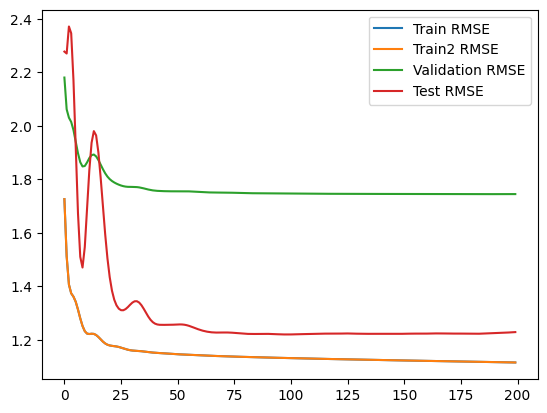

In [ ]:
# Print epoch with minimum RMSE
print('Min RMSE for training data at epoch:', np.argmin(train_rmse)+1)
print('Min RMSE for valid data at epoch:', np.argmin(valid_rmse)+1)
print('Min RMSE for test data at epoch:', np.argmin(test_rmse)+1)

# Plot RMSE
plt.plot(train_rmse, label='Train RMSE')
plt.plot(train2_rmse, label='Train2 RMSE')
plt.plot(valid_rmse, label='Validation RMSE')
plt.plot(test_rmse, label='Test RMSE')

plt.legend()
plt.show()

## Final model predictions

**CHECKPOINT 6**


---

We are now going to train the final model with the hyper-tuned number of epochs (variable valid_epochs). Replace REPLACEME in the code below to do this.

In [ ]:
# train the final model
model = createModel()

batch_size = len(X_train)

# use the number of epoch chosen through validation (valid_epoch)
REPLACEME

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model (validation data is now test data)
tf.keras.utils.set_random_seed(42)
REPLACEME

# create predictions
y_test_hat = model.predict(X_test)


Epoch 1/183
1/1 [==============================] - 1s 1s/step - loss: 2.9815 - val_loss: 5.1893
Epoch 2/183
1/1 [==============================] - 0s 288ms/step - loss: 2.2891 - val_loss: 5.1568
Epoch 3/183
1/1 [==============================] - 0s 266ms/step - loss: 1.9803 - val_loss: 5.6260
Epoch 4/183
1/1 [==============================] - 0s 283ms/step - loss: 1.8890 - val_loss: 5.5061
Epoch 5/183
1/1 [==============================] - 0s 273ms/step - loss: 1.8551 - val_loss: 4.7189
Epoch 6/183
1/1 [==============================] - 0s 284ms/step - loss: 1.8033 - val_loss: 3.6822
Epoch 7/183
1/1 [==============================] - 0s 257ms/step - loss: 1.7255 - val_loss: 2.8004
Epoch 8/183
1/1 [==============================] - 0s 275ms/step - loss: 1.6406 - val_loss: 2.2828
Epoch 9/183
1/1 [==============================] - 0s 253ms/step - loss: 1.5682 - val_loss: 2.1636
Epoch 10/183
1/1 [==============================] - 0s 279ms/step - loss: 1.5200 - val_loss: 2.3943
Epoch 11/183

## Hedge portfolio on test data (OPTIONAL)

Are our predictions working? Can we make money from trading on those prediction?
To answer these questions, we can construct a *hedge portfolio*, also known as a *zero cost portfolio* or *long-short strategy*.

The idea is to sort stocks in each year by their predicted return. At the start of the *following year*, buy the top-10% of stocks and sell the bottom 10% of stocks. Do this for each year.

This is one way (there are others) to convert predicted returns into an implementable trading strategy. One could also do this more frequently (monthly, weekly, daily or even intra-day).

In [ ]:
# Get numpy arrays for a) the year, b) true return and c) predicted returns
years = test.year.to_numpy()
true_returns = y_test.to_numpy()
pred_returns = y_test_hat.ravel()

# Create a DataFrame for ease of calculation
df = pd.DataFrame({'Year': years, 'True Return': true_returns, 'Predicted Return': pred_returns})

# Group by year and calculate deciles
df['Decile'] = df.groupby('Year')['Predicted Return'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# Calculate mean true return by year and decile
mean_returns = df.groupby(['Year', 'Decile'])['True Return'].mean().reset_index()

decile_low  = mean_returns[mean_returns['Decile'] == 0]
decile_high = mean_returns[mean_returns['Decile'] == 9]

# Merging the two datasets on 'Year' to align them
merged_deciles = pd.merge(decile_low, decile_high, on='Year', suffixes=('_Decile_Low', '_Decile_High'))

# Calculating the hedge portfolio as the difference of returns between decile 9 and decile 0
merged_deciles['HP'] = merged_deciles['True Return_Decile_High'] - merged_deciles['True Return_Decile_Low']

# Resulting DataFrame contains year and the hedge portfolio return
strategy = merged_deciles[['Year', 'HP']]


In [ ]:
strategy

,Year,HP
0,2002,0.619812
1,2003,0.199126
2,2004,0.088337
3,2005,0.246528
4,2006,0.094617
5,2007,-0.156280
6,2008,0.117398
7,2009,-0.011033
8,2010,-0.039035
9,2011,0.088645


In [ ]:
strategy.HP.mean()

0.10978918262695421

## Plot trading strategy returns by year

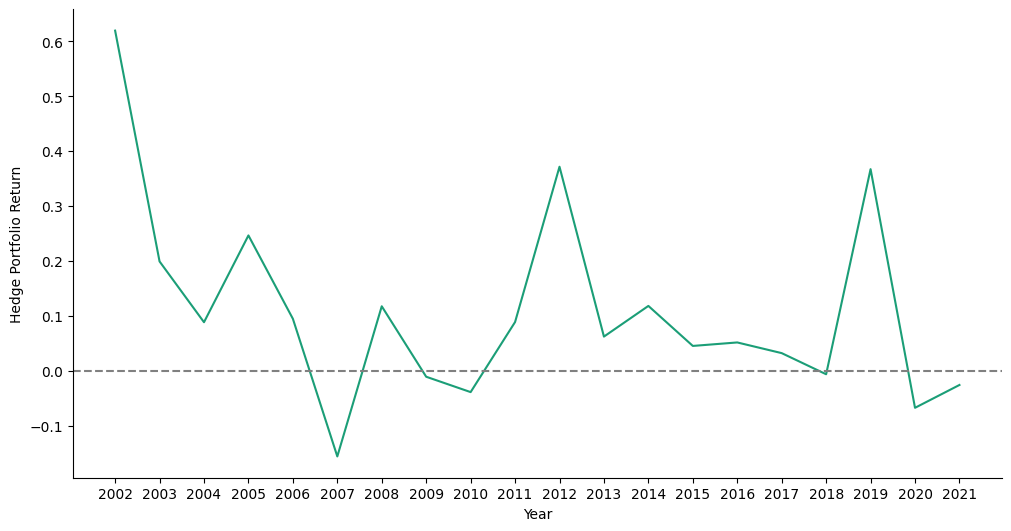

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index, palette):
    xs = series['Year']
    ys = series['HP']
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Setup plot
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
palette = list(sns.palettes.mpl_palette('Dark2'))

# Sort DataFrame and plot
df_sorted = strategy.sort_values('Year', ascending=True)
_plot_series(df_sorted, '', 0, palette)

# Add a horizontal line at y=0
plt.axhline(0, color='grey', linestyle='--')

# Set x-axis to display integers
plt.xticks(df_sorted['Year'].unique(), df_sorted['Year'].unique().astype(int))

# Finalize plot
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Hedge Portfolio Return')
plt.show()

As you can see, the trading strategy does very well. It makes profits in most years, and the typical profit per year is around 11%.

Two things to remember:

1) *It is easy to predict future returns in past data.* <- what we just did.

2) *It is hard to predict future returns in the future.*

Good luck!